In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

First lets load our data

In [2]:
data = pd.read_csv("./data/iris.csv")
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We will represent species (or classes) as integers instead of their names. To do this we will use sci-kit's LabelEncoder

In [3]:
label_enc = LabelEncoder()
data["species"] = label_enc.fit_transform(data["species"])

In [4]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Lets check how many classes we have and number of samples belonging to each class. As you can see we have a uniformly distributed data. Each class has 50 samples

In [5]:
print(np.unique(data["species"],return_counts=True))

(array([0, 1, 2]), array([50, 50, 50]))


A decision tree consists of a set of questions about the input. Depending on the answers to these questions we move forward (or down since its a tree) in the tree. We do this until we get to a point where there are no more questions. Which is called a leaf. Our label predicted by our tree is located at this leaf. The parts of the tree which have questions are called the nodes. Lets give a simple example. Lets take the sepal_length feature and say that we have a threshold of 4.6. Each node two child nodes. One child node is called left and the other one is called the right child node. Lets say that sepal_length is 4.8 for a sample. When we come to this node we will compare the input's sepal_length (4.8) with threshold value (4.6). Our sepal_legnth value is higher which means we will move to the right node. If our sepal_length was smaller than the threshold we would go to the left node. So on each node we have a threshold value and two child nodes. Left child node is for the samples with smaller value than our threshold and right child node is for the samples with higher value than our threshold. To classify a sample we go trough each node, compare the threshold and our feature to decide which way to move until we have no more child nodes to go (until we arrive to a leaf node). In this example we only use continues non-categorical input and implement our decision tree for this type of inputs. Now we will look at how we build a decision tree, how we decide value of the threshold and in which order we put our questions.



As we have said in a decision tree we compare the threshold values and input features. A feature can be used more than once. So we can have two nodes making comparisons using the same feature. To build the tree we have to solve the following problems: How do we decide which features to use? What will be the order of these features in the tree? There are multiple popular ways to solve this problem such as entropy or gini impurity. These two are metric which shows how homogenous our distribution is. Since we have a classifier we want each class to be seperate at the end. So lets say we have some samples with labels: [0,1,0,0,1]. After we pass our samples trough a node the samples will be divided into two (left and right child nodes). So the ideal seperation would be [0,0,0], [1,1]. If our training data was only this an if we could have achieved this with a single node we would not add other nodes to the tree. So on each node we want to seperate each class as much as possible. We will use gini impurity for this. If you calculate gini impurity for [0,0,0] the result will be zero. So we want lower values of gini impurity at each node. 

In [6]:
def compute_gini(data):
    _ , counts = np.unique(data,return_counts=True)

    gini = (counts/len(data))**2

    gini = 1 - gini.sum()
    return gini

def weighted_gini(data): # a list of arrays (two element list)
    w_gini = []
    n = 0
    
    for i in data:
        gini = compute_gini(i)
        w_gini.append(gini * len(i)) 
        n+=len(i)
        
    w_gini = np.array(w_gini)/n
    return w_gini.sum()

The gini impurity formula is: $1 - \sum_{i=0}^{c} p_i^2$. Here c is the number of classes and p is the probabilty of the class. We can easily compute $p$ as number of samples with label i/ total number of samples. Gini impurity is calculated by compute_gini function. Remember that a node seperates the inputs into two groups. So we can't caclulate a single gini impurity. So for a node we calculate the weighted gini impurity. We calculate  the gini impurity for both child nodes. We multiply each node with the number of samples it has and divide by the total number of samples. Now lets look at different cases and calculate gini impurity.

In [7]:
print(compute_gini(np.array([0,0,0,0,0])))
print(compute_gini(np.array([1,1,0,0,0])))
print(compute_gini(np.array([1,1,1,0,0])))
print(compute_gini(np.arange(100)))

0.0
0.48
0.48
0.99


As you can see when all samples are same in an input gini impurity is zero. As we add sampels with different labels gini impurity increases. Gini impurity of second and third example is same because in both cases sample ratio is 2-3. In second example there are 2 ones and 3 zeros whereas in the third example there are 2 ones and 3 zeros. Lastly in a case of 100 samples with different labels the gini impurity becomes close to 1 (which is the limit). 

Lets move on to calculation of the threshold and how to pick the feature. For a given feature lets say our values are [3.5,0.5,2]. First we sort our values: [0.5,2,3.5]. Then we calculate the average of every neigbour element: [1.25,2.75]. Now we have two candidates for our threshold value. We calculate weighted gini impurity for each candidate. Then we pick the threshold which gives us the lowest gini impurity (the one that seperate the classes most). These steps are implemented in gini_select function below.

In [8]:
def gini_select(X,Y): # X is data for only a single feature
    X2 = X.copy() # we create a copy of X just for finding the thresholds (we don't want to sort the original data)
    X2 = X2.sort_values()
 
    thresholds = X2.rolling(2).mean()[1:] # moving average, since first value is NAN we remove it

    unique_vals , _ = np.unique(thresholds,return_counts=True) # get each unique threshold value
    
    gini_list = []

    for tresh in unique_vals: #iterate over each threshold
        # seperate the data using threshold
        left_d = np.where(X<tresh)[0] # actually we can iterate over thre X once and use if<thresh,else to divide data
        right_d = np.where(X>=tresh)[0] # and not use np.where twice but numpy is faster than regular for loop

        gini = weighted_gini([Y.iloc[left_d],Y.iloc[right_d]]) #select elements of Y (labels) and calculate gini
        gini_list.append(gini)

    arg_min = np.argmin(gini_list) #select lowest gini val
    thres_val = unique_vals[arg_min] # select threshold for lowest gini
    gini = gini_list[arg_min]
    return thres_val,gini

Now we have learned how to pick the threshold value but how do we pick which feature to use? More importantly in which order should we use our features? The answer is simple, we are going to pick our features in the way we have picked up our threshold. We will iterate over each feature, for each feature we will calcuate the threshold and gini impurity. Then we will pick up the feature which gives us the lowest gini impurity. 

In [9]:
def find_split_feature(data): # data is a pandas dataframe
    feature_select_list = []
    
    for feature_name in data.columns[:-1]:
        split_val,gini = gini_select(data[feature_name],data.iloc[:,-1])
        feature_select_list.append([feature_name,gini,split_val])
  
    feature_select_list = np.array(feature_select_list)
    arg_min = np.argmin(feature_select_list[:,1])
    
    feature_name = feature_select_list[arg_min,0]
    threshold = feature_select_list[arg_min,2]
    gini_val = feature_select_list[arg_min,1]
    
    #because we can not have np arrays with different typed
    #elements numpy changed everything into string (due to feature name being a string) now we have to revert it
    return feature_name,float(threshold),float(gini_val)     

Lets calculate the feature that will be on top of our tree.

In [10]:
find_split_feature(data)

('petal_length', 2.45, 0.3333333333333333)

In [11]:
a = np.where(data[["petal_length"]].values<2.45)
print(a[1])
print(len(a[1]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
50


On the cell above we have checked which samples are under our threshold value. As you can see all examples with label 0 are seperated with just using petal_length (there are 50 samples with label 0). So just in the first node we are able to seperate a whole class! 

Now lets move on to building our tree. As we have said before a tree consists of nodes. So we will first create a Node class and then a tree class. 

In [12]:
"""

Diğer fonkisyonları ağaca eklememe sebebimiz üzerlerinden geçmek ve class'ın şişmemesi



"""

"\n\nDiğer fonkisyonları ağaca eklememe sebebimiz üzerlerinden geçmek ve class'ın şişmemesi\n\n\n\n"

In [13]:
class Node():
    def __init__(self):
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.label = None

    def __repr__(self):
        if self.feature == None:
            return "Leaf->Label: {}".format(self.label)
        else:
            return "Node->Feature: {} Threshold: {}".format(self.feature,self.threshold)

Each node has a left and right node. In the consturctor we initialize them as None but we will later add another node toe left and right of our node. To be able to print our node we have the repr function. If our node is a leaf we print out the label, if not we print the threshold and the name of the feature that seperates the input.

In [14]:
class DesicionTree():
    def __init__(self):
        self.root = Node()

    def build_tree(self,node,data): # data is pandas dataframe

    
        gini = compute_gini(data.iloc[:,-1])
        if gini!=0:
            feature_name,threshold, gini = find_split_feature(data)

            node.feature = feature_name
            node.threshold = threshold

            d = data[feature_name]

            left_d = data.iloc[np.where(d<threshold)[0],:] 
            right_d = data.iloc[np.where(d>=threshold)[0],:]
            
            node.left = Node()
            self.build_tree(node.left,left_d)
            
            node.right = Node()
            self.build_tree(node.right,right_d)
            
        else:
            unique_vals , _ = np.unique(data.iloc[:,-1],return_counts=True)
            node.label = unique_vals[0]
            
    def predict(self,node,data): # data is a pandas dataframe with a single sample
        if node.label==None:
            d = data[node.feature]

            if d<node.threshold:

                return self.predict(node.left,data)
            else:

                return self.predict(node.right,data)
        else:

            return node.label
        
    def predict_dataset(self,data): # data is a pandas dataframe
        output = []
        for i in range(len(data)):
            output.append(self.predict(self.root,data.iloc[i,:-1]))
        return np.array(output)
    
            

You can see that our tree has only a root node. We have three methods in our class. We will go over them one by one. First method is build_tree. As you can see it is a recursive function (which means it calls it self). First we check the gini impurity (not weighted gini) to see if our data consist of a single class. If it is we don't need more seperation. If not we find which feature splits the data best. Then we add the threshold and feature name to our node and divide our data into two. Then we add the left child node to our node and pass the child node and left portion of data into build tree. As you can see we will return to the top of  build_tree. So we will continue doing this until we don't need more seperation (gini = 0). Then we will start going back and calculating the right side. If this recursion method is confusing you can grab a pen and a paper and try to build a small tree with just a couple of samples by hand. 

Our second method is predict. As you can tell by its name it is used for predicting the label of a sample. Again we use recursion and go trough the nodes of our tree until we come to a leaf node.

Lastly predict_dataset method is for predicting labels of an entire dataset using a single method.

In [15]:
tree = DesicionTree()
tree.build_tree(tree.root,data)

In [16]:
tree.predict_dataset(data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [23]:
tree.root.right.right

Node->Feature: petal_length Threshold: 4.85

In [24]:
tree.root.threshold

2.45

In [25]:
tree.root.right.right.right

Leaf->Label: 2

In [26]:
plt.rcParams["figure.figsize"] = (15,5) # make figures larger

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
r = np.random.randint(0,150,50)

In [36]:
data2 = data.iloc[r,:]

In [38]:
a = DesicionTree()
a.build_tree(a.root,data2)

In [39]:
out_e = tree.predict_dataset(data2)

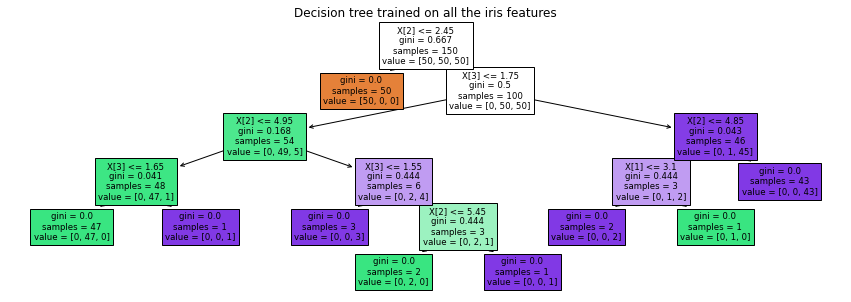

In [40]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
plt.figure()
clf = DecisionTreeClassifier().fit(data.iloc[:,:-1], data.iloc[:,-1])
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

In [41]:
c = clf.predict(data2.iloc[:,:-1])

In [42]:
(c == out_e).sum()

50

In [ ]:
clf

In [43]:
help(plot_tree)

Help on function plot_tree in module sklearn.tree._export:

plot_tree(decision_tree, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, impurity=True, node_ids=False, proportion=False, rotate='deprecated', rounded=False, precision=3, ax=None, fontsize=None)
    Plot a decision tree.
    
    The sample counts that are shown are weighted with any sample_weights that
    might be present.
    
    The visualization is fit automatically to the size of the axis.
    Use the ``figsize`` or ``dpi`` arguments of ``plt.figure``  to control
    the size of the rendering.
    
    Read more in the :ref:`User Guide <tree>`.
    
    .. versionadded:: 0.21
    
    Parameters
    ----------
    decision_tree : decision tree regressor or classifier
        The decision tree to be plotted.
    
    max_depth : int, default=None
        The maximum depth of the representation. If None, the tree is fully
        generated.
    
    feature_names : list of strings, defa